In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

%config InlineBackend.figure_format = 'retina'

In [4]:
# Read data e change column name
raw_states_df = pd.read_csv('covid19-37498d300a474505b1adb1e078f107b5.csv',
                     usecols=[1,3,7],
                     parse_dates=['date'],
                     squeeze=True
                     ).sort_index()

raw_states_df['cases']= raw_states_df['last_available_confirmed']
raw_states_df.drop(['last_available_confirmed'],axis=1, inplace=True)
raw_states_df

,date,state,cases
0,2020-06-18,AC,181
1,2020-06-18,AC,128
2,2020-06-18,AC,236
3,2020-06-18,AC,124
4,2020-06-18,AC,107
...,...,...,...
228402,2020-02-27,SP,1
228403,2020-02-26,SP,1
228404,2020-02-26,SP,1
228405,2020-02-25,SP,1


In [5]:
# Group by state and convert to pd.Series
states_df = raw_states_df.groupby(['state','date']).sum()
states = states_df.squeeze()

states

state  date      
AC     2020-03-17        6
       2020-03-18        6
       2020-03-19        8
       2020-03-20       14
       2020-03-21       22
                     ...  
TO     2020-06-14    14274
       2020-06-15    14618
       2020-06-16    15146
       2020-06-17    15548
       2020-06-18    15548
Name: cases, Length: 2650, dtype: int64

# Set up Data

### run an example for a single state

Use a gaussian filter to smooth the data

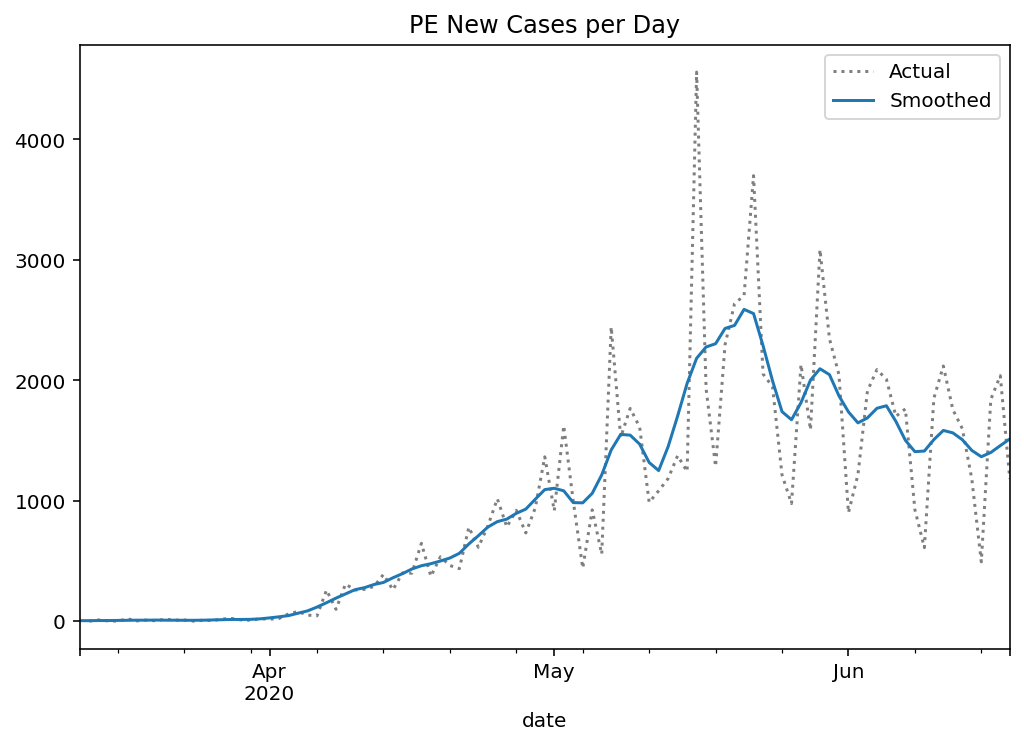

In [8]:
state_name = 'PE'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

In [13]:
# SET UP PARAMETERS
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)


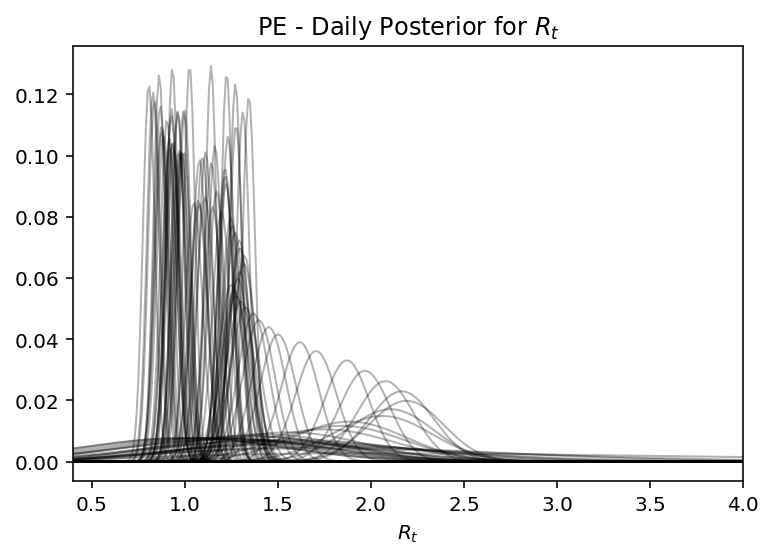

In [14]:
# PLOT POSTERIOR DISTRIBUTION FOR RT

ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

# Highest Density Interval for Rt

##### "What is the most likely value of 𝑅𝑡 each day?"

In [15]:
def highest_density_interval(pmf, p=.95):
    low = ''
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
    
    # I had to do this because some points in best are None, due to the data quality
    if best is not None:     
        low = pmf.index[best[0]]
        high = pmf.index[best[1]]
    else:
        low = float('nan')
        high = float('nan')

    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)



most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)


result.tail()

,ML,Low,High
date,,,
2020-06-14,0.97,0.89,1.05
2020-06-15,0.98,0.90,1.06
2020-06-16,1.00,0.92,1.08
2020-06-17,0.98,0.90,1.06
2020-06-18,0.97,0.89,1.05


# Plotting the Result

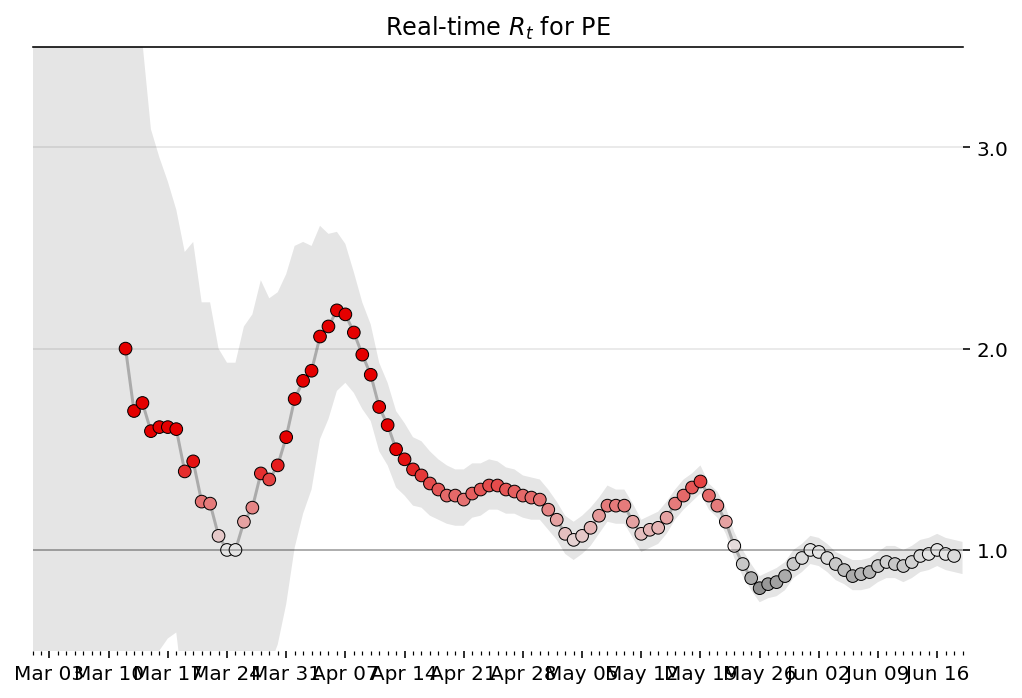

In [16]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Computing the results for all States

In [17]:
FILTERED_REGIONS = []
 
results = {}

states_to_process = states.loc[~states.index.get_level_values('state').isin(FILTERED_REGIONS)]

for state_name, cases in states_to_process.groupby(level='state'):
    clear_output(wait=True)
    print(f'Processing {state_name}')
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
           
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[state_name] = result.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


# Plot all States

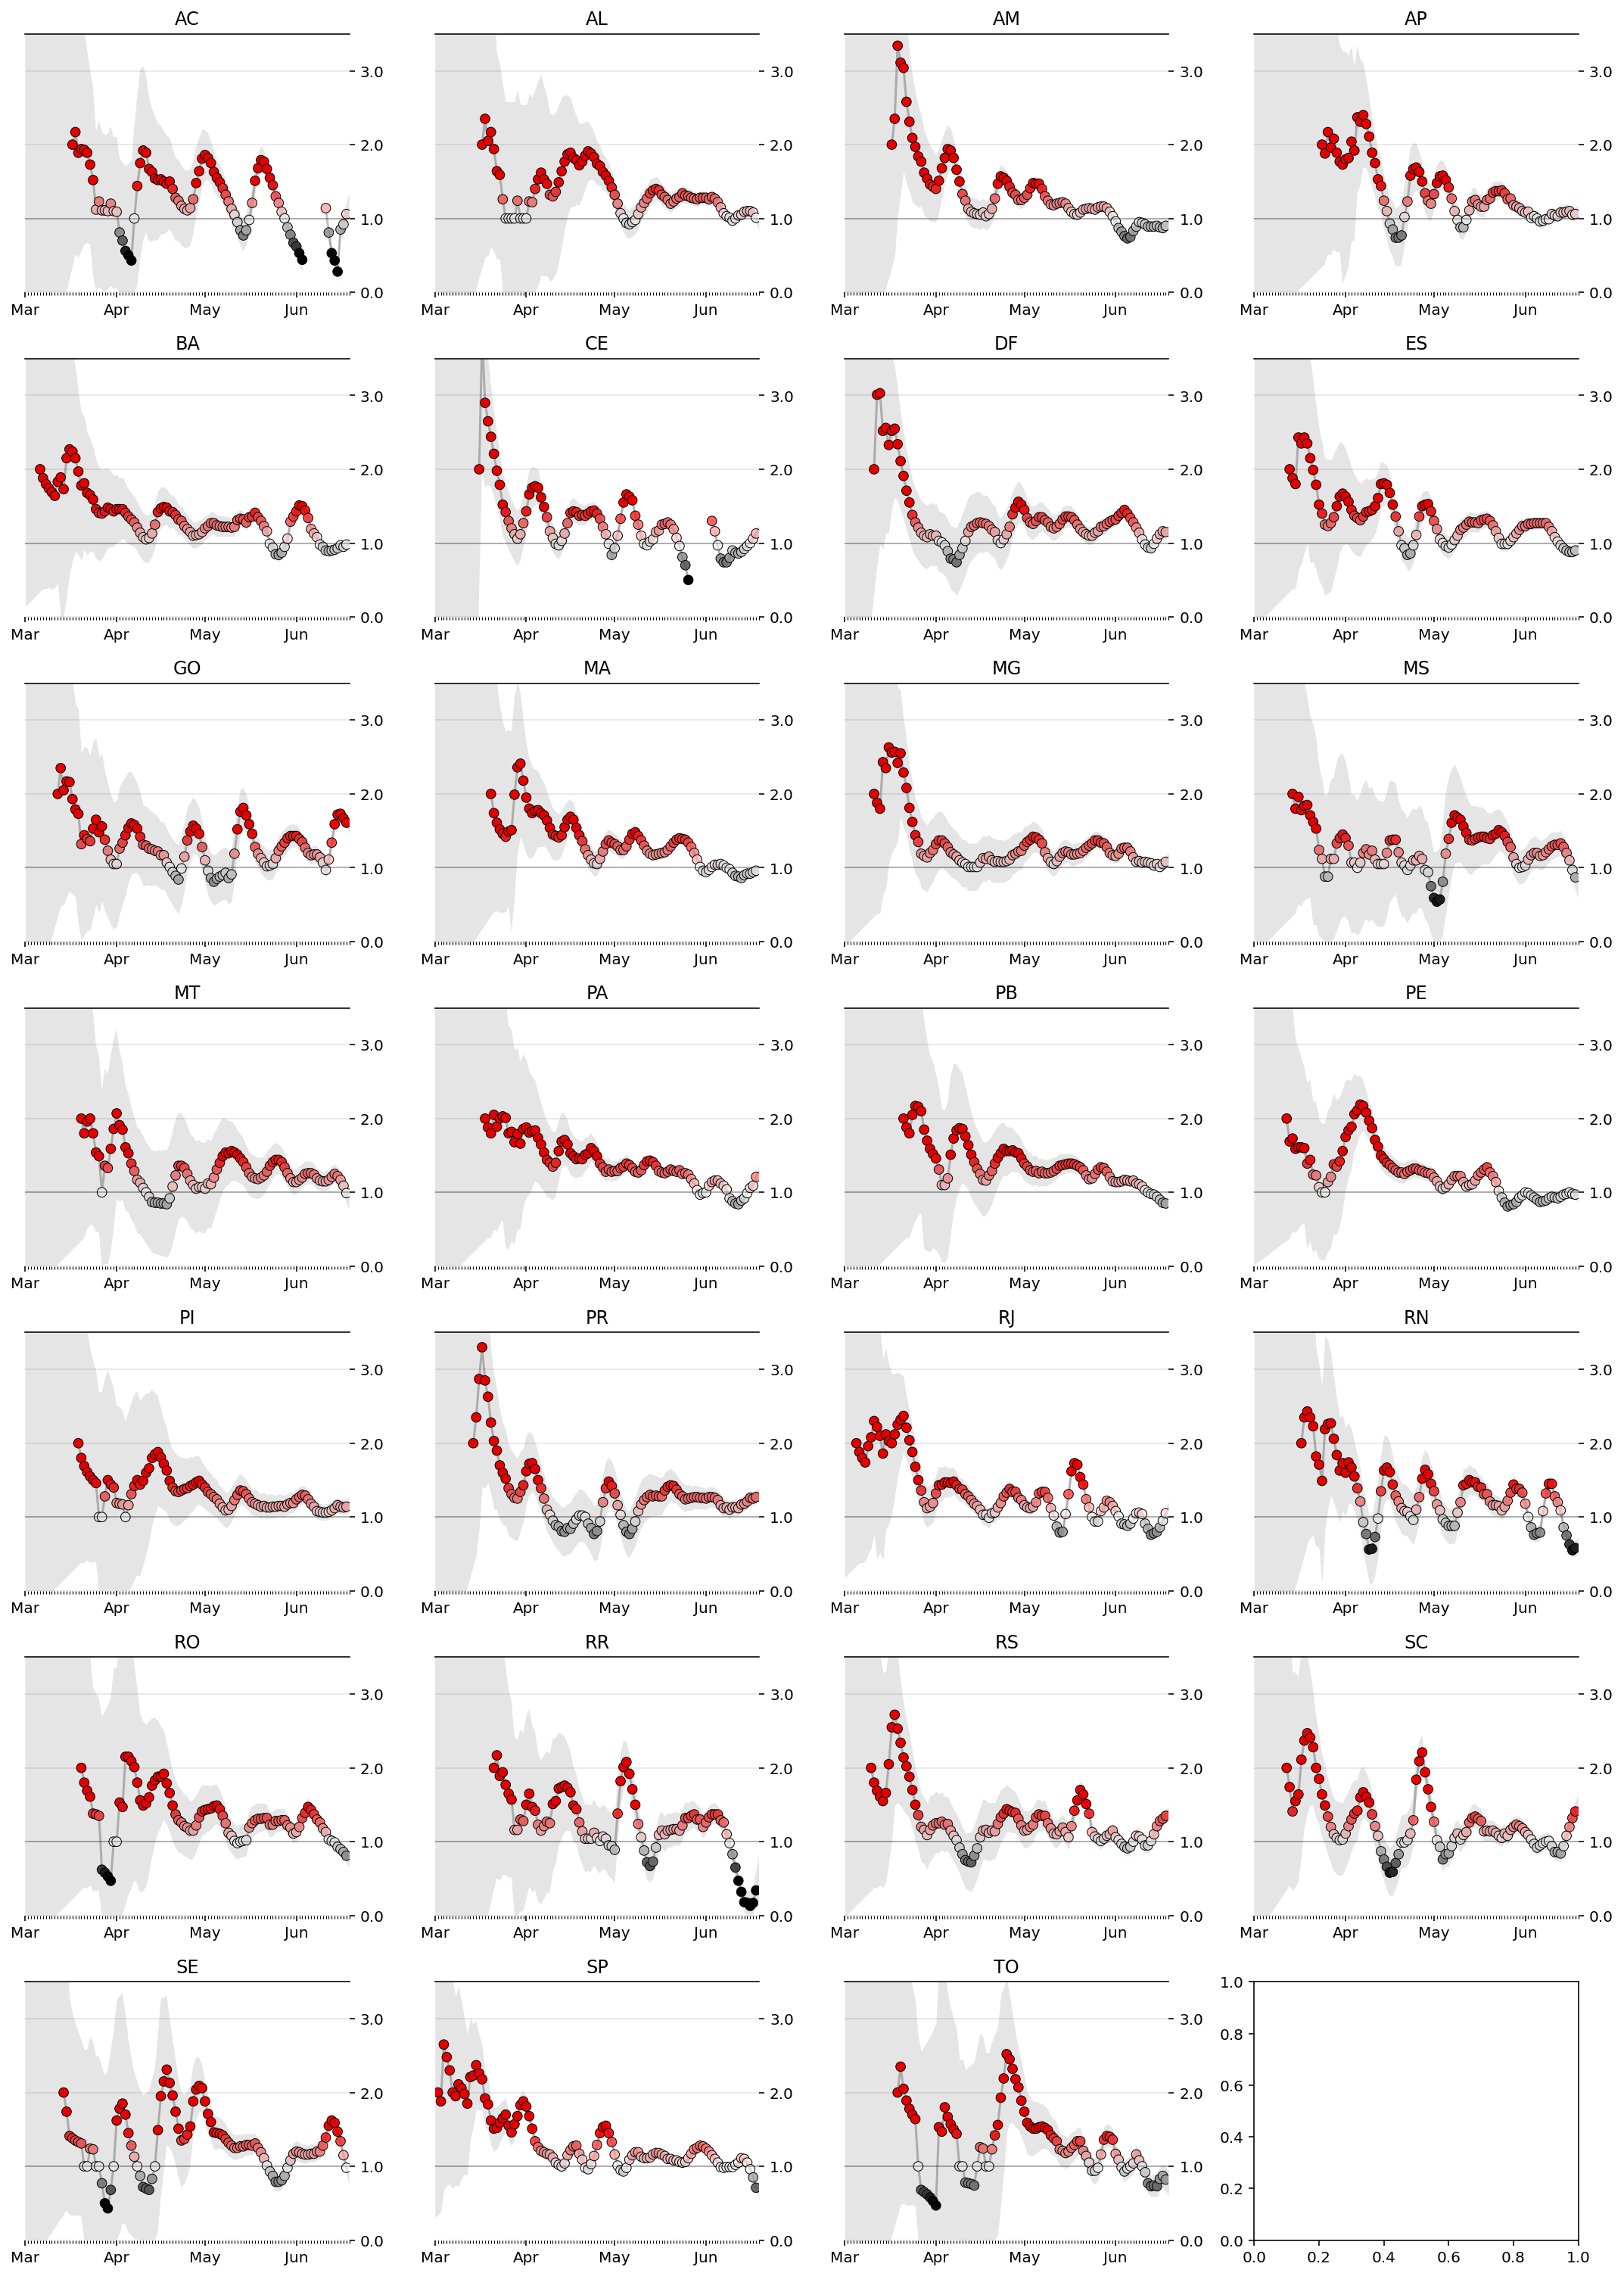

In [18]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

In [19]:
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)
# Uncomment this line if you'd like to export
# overall.to_csv('data/rt.csv')

In [20]:
# As of 4/12
no_lockdown = [
    'PI',
    'RR',
    'AC',
    'MT',
    'MS',
    'GO',
    'PR',
    'RS',
    'SC',
    'SP'
]
partial_lockdown = [
 'AL',
 'AM',
 'AP',
 'BA',
 'CE',
 'DF',
 'ES',
 'MA',
 'MG',
 'PA',
 'PB',
 'PE',
 'RJ',
 'RN',
 'RO',
 'SE',
 'TO'
    

]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

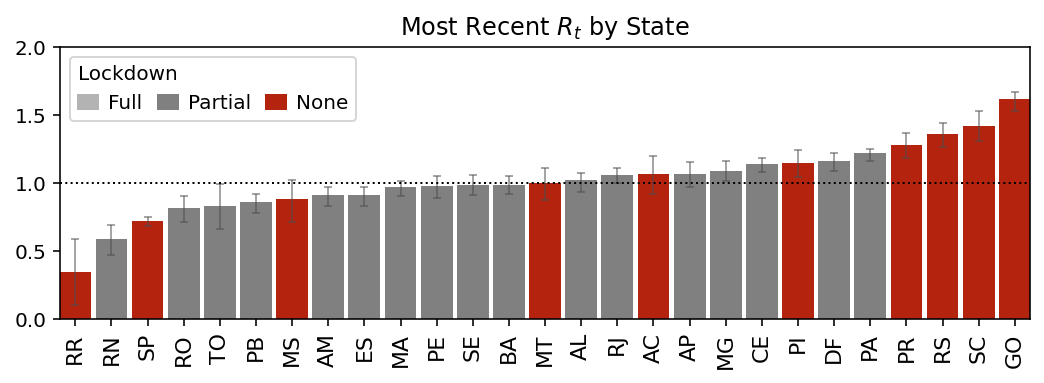

In [21]:
filtered = overall.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = overall.loc[~filtered].groupby(level=0)[['ML', 'High', 'Low']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

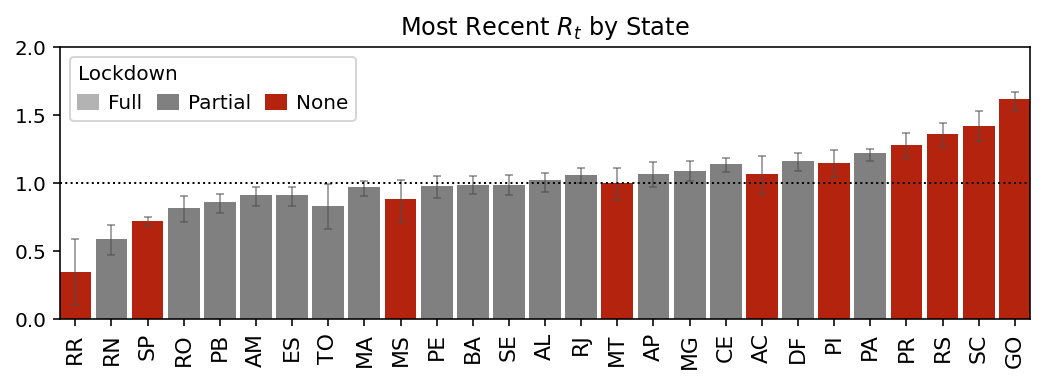

In [22]:
mr.sort_values('High', inplace=True)
plot_standings(mr);

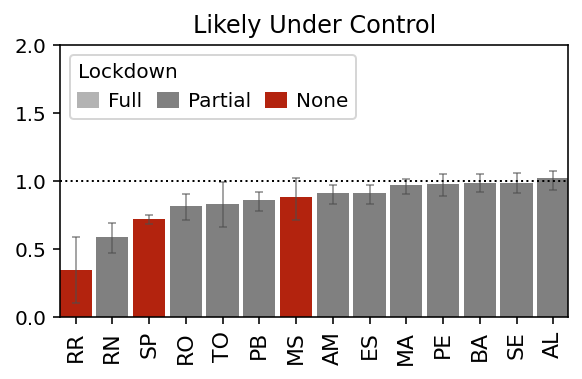

In [23]:
show = mr[mr.High.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

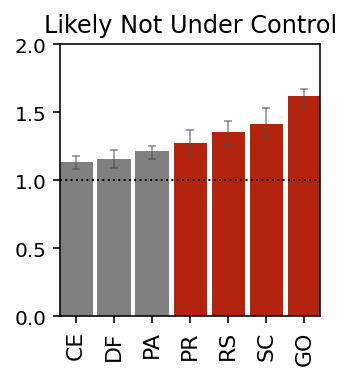

In [24]:
show = mr[mr.Low.ge(1.05)].sort_values('Low')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()